<a href="https://colab.research.google.com/github/rnop/WSB-Top-Tickers-and-Sentiment-Analysis-Project/blob/main/Sentiment_Analysis_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis - Visualization

Check previous notebooks on how to scrape Reddit data and to compute sentiment using VADER and BERT Transformers.

In [142]:
import pandas as pd
import ast

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [143]:
comments_df = pd.read_csv('bert_vader_sentiment_comments.csv')
comments_df['date'] = pd.to_datetime(comments_df['date'])
comments_df = comments_df.set_index('date')
comments_df.dropna(inplace=True)
comments_df['ticker_in_comment'] = [ast.literal_eval(item) for item in comments_df['ticker_in_comment']] # convert strings to list
comments_df = comments_df[comments_df['comment'].map(len) <= 128] # Remove comments over 128 words for transformer
print("Shape: ", comments_df.shape)
comments_df.sample(10)

Shape:  (199075, 7)


,comment,title,ticker_in_comment,bertweet_sentiment_label,bertweet_sentiment_score,vader_sentiment,vader_sentiment_label
date,,,,,,,
2021-09-27,BABA Green ! ? ! ? What strange magical la...,"Daily Discussion Thread for September 27, 2021","[LAND, BABA]",NEG,0.504418,0.5753,POS
2021-08-12,They need to have options on warrants It woul...,"Daily Discussion Thread for August 12, 2021",[],NEU,0.960785,0.3612,POS
2021-07-13,This whole market is basically 🐻🌈 conversion t...,"Daily Discussion Thread for July 13, 2021",[],NEG,0.844286,-0.6908,NEG
2021-12-06,Turns out I can remain irrational longer than ...,"Daily Discussion Thread for December 06, 2021",[],NEG,0.622814,-0.3400,NEG
2021-01-19,BB will not dip it will gap up tomorrow i have...,"Daily Discussion Thread for January 19, 2021",[BB],NEU,0.833568,0.0000,NEU
2021-05-07,Cathie never wears pants during interviews Y...,"Daily Discussion Thread for May 07, 2021",[],POS,0.639776,0.4588,POS
2021-11-23,I m scared daddy,"Daily Discussion Thread for November 23, 2021",[],NEG,0.939792,-0.4404,NEG
2021-09-14,Inflation truly is transitory,"Daily Discussion Thread for September 14, 2021",[],NEU,0.949575,0.4404,POS
2021-07-16,Every trade I ve made today has flipped within...,"Daily Discussion Thread for July 16, 2021",[],NEU,0.722075,0.0000,NEU


In [144]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199075 entries, 2021-01-01 to 2021-12-09
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   comment                   199075 non-null  object 
 1   title                     199075 non-null  object 
 2   ticker_in_comment         199075 non-null  object 
 3   bertweet_sentiment_label  199075 non-null  object 
 4   bertweet_sentiment_score  199075 non-null  float64
 5   vader_sentiment           199075 non-null  float64
 6   vader_sentiment_label     199075 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.2+ MB


## Most Mentioned Stocks on WSB
* Yearly, Monthly, Weekly, Daily Intervals

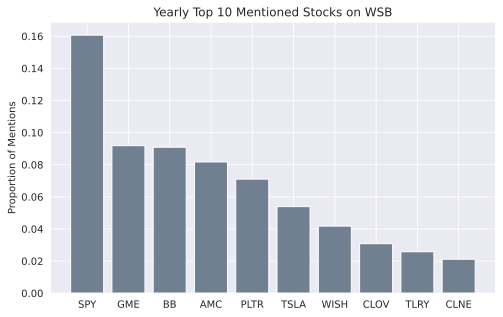

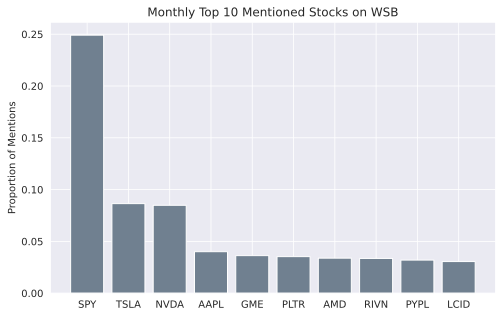

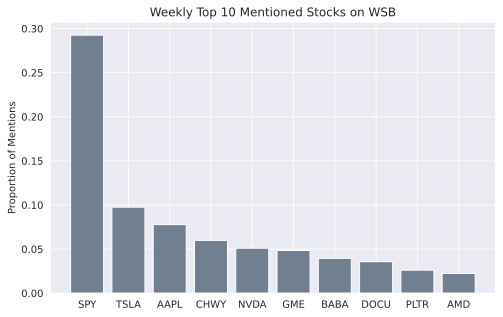

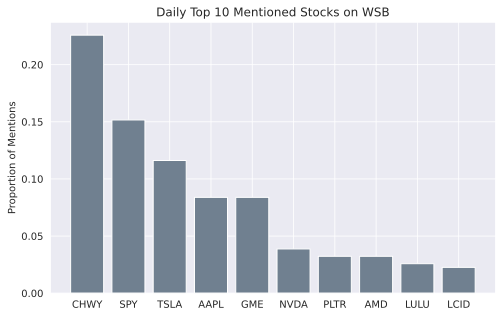

In [145]:
def most_mentioned_stocks(comments, period):
  '''
  Counts the most mentioned stocks on WSB given a specific time period.
  Period: ['Yearly', 'Monthly', 'Weekly','Daily']
  '''
  if period=='Daily':
    earliest_dt = comments_df.index[-1]
    latest_dt = comments_df.index[-1]

  if period=='Weekly':
    earliest_dt = comments_df.index[-1] - pd.Timedelta(weeks=1)
    latest_dt = comments_df.index[-1]

  if period=='Monthly':
    earliest_dt = comments_df.index[-1] - pd.Timedelta(weeks=4.35)
    latest_dt = comments_df.index[-1]

  if period=='Yearly':
    earliest_dt = comments_df.index[-1] - pd.Timedelta(weeks=52)
    latest_dt = comments_df.index[-1]

  df = comments_df.loc[earliest_dt:latest_dt]

  mentioned_tickers = []
  for list_tickers in df['ticker_in_comment'].values:
    for ticker in list_tickers:
      mentioned_tickers.append(ticker)

  most_common_tickers_cnts = pd.Series(mentioned_tickers).value_counts(0)
  most_common_tickers_pcts = pd.Series(mentioned_tickers).value_counts(1)

  plt.figure(figsize=(8,5))
  plt.title(f"{period} Top 10 Mentioned Stocks on WSB")
  plt.ylabel('Proportion of Mentions')
  plt.bar(most_common_tickers_pcts[:10].index, height=most_common_tickers_pcts[:10].values, color='slategrey')
  plt.show()

most_mentioned_stocks(comments_df, 'Yearly')
most_mentioned_stocks(comments_df, 'Monthly')
most_mentioned_stocks(comments_df, 'Weekly')
most_mentioned_stocks(comments_df, 'Daily')

## Individual Stocks - SPY/GME/TSLA

In [146]:
def plot_individual_stocks(stock_ticker, comments_df, period):
  ticker_check = [True if stock_ticker in ticker_in_comment else False for ticker_in_comment in comments_df['ticker_in_comment'].values]
  individual_ticker_df = comments_df[ticker_check]
  period_dict = {'Yearly':'Y', 'Monthly':'M', 'Weekly':'W', 'Daily':'D'}

  if period=='Daily':
    start = individual_ticker_df.index[-1] - pd.Timedelta(days=31)
    end = individual_ticker_df.index[-1]
    individual_ticker_df = individual_ticker_df.loc[start:end]

    individual_ticker_df = pd.DataFrame(individual_ticker_df.groupby(['date', 'vader_sentiment_label']).count()).reset_index().pivot(index='date', columns='vader_sentiment_label')['comment']
    individual_ticker_df.index = pd.to_datetime(individual_ticker_df.index) # Resample requires datetime index
    individual_ticker_df = individual_ticker_df.resample(period_dict[period]).sum()
    individual_ticker_df.index = individual_ticker_df.index.map(lambda t: t.strftime('%Y-%m-%d'))

    plt.figure(figsize=(10,5))
    sns.barplot(x=individual_ticker_df.index, y=individual_ticker_df['POS'], color='green', alpha=0.5, label='Positive')
    sns.barplot(x=individual_ticker_df.index, y=individual_ticker_df['NEG'], color='maroon', alpha=0.5, label='Negative')
    plt.title(f"{period} Sentiment of {stock_ticker} (31 Days)")
    plt.ylabel('Sentiment Counts')
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
  
  else:
    individual_ticker_df = pd.DataFrame(individual_ticker_df.groupby(['date', 'vader_sentiment_label']).count()).reset_index().pivot(index='date', columns='vader_sentiment_label')['comment']
    individual_ticker_df.index = pd.to_datetime(individual_ticker_df.index) # Resample requires datetime index
    individual_ticker_df = individual_ticker_df.resample(period_dict[period]).sum()
    individual_ticker_df.index = individual_ticker_df.index.map(lambda t: t.strftime('%Y-%m-%d'))

    plt.figure(figsize=(10,5))
    sns.barplot(x=individual_ticker_df.index, y=individual_ticker_df['POS'], color='green', alpha=0.5, label='Positive')
    sns.barplot(x=individual_ticker_df.index, y=individual_ticker_df['NEG'], color='maroon', alpha=0.5, label='Negative')
    plt.title(f"{period} Sentiment of {stock_ticker}")
    plt.ylabel('Sentiment Counts')
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

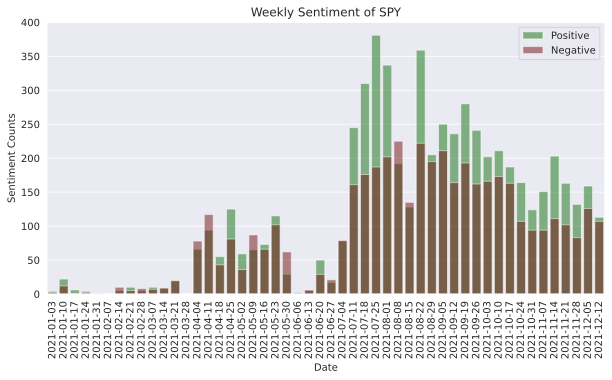

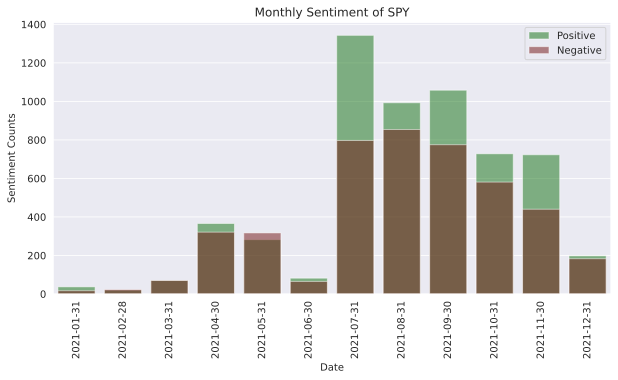

In [147]:
plot_individual_stocks('SPY', comments_df, period='Weekly')
plot_individual_stocks('SPY', comments_df, period='Monthly')

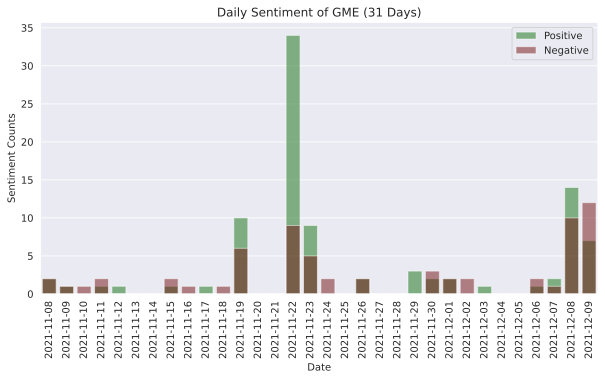

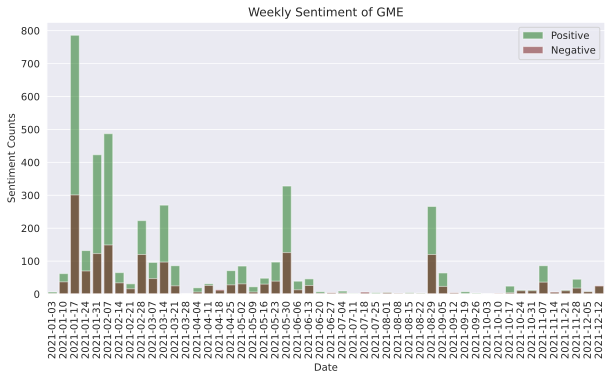

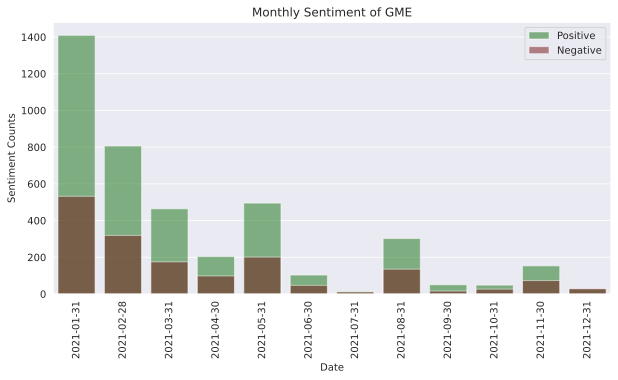

In [148]:
plot_individual_stocks('GME', comments_df, period='Daily')
plot_individual_stocks('GME', comments_df, period='Weekly')
plot_individual_stocks('GME', comments_df, period='Monthly')

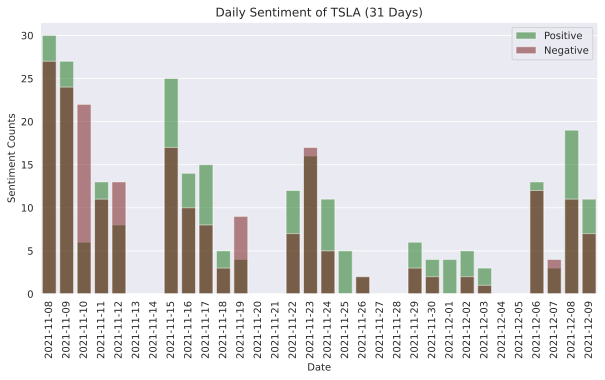

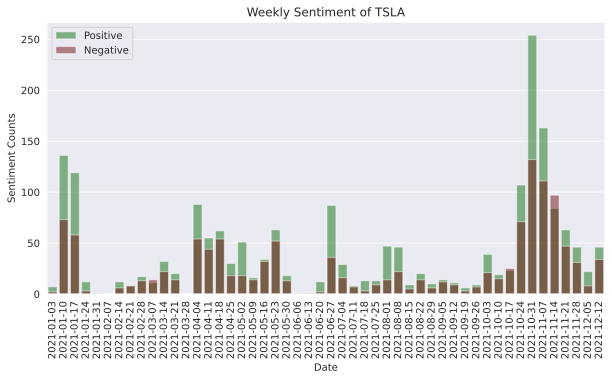

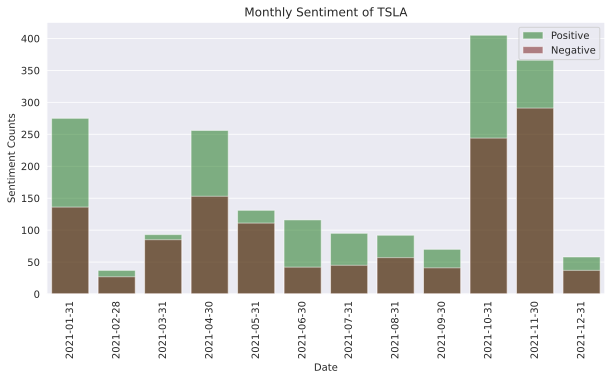

In [149]:
plot_individual_stocks('TSLA', comments_df, period='Daily')
plot_individual_stocks('TSLA', comments_df, period='Weekly')
plot_individual_stocks('TSLA', comments_df, period='Monthly')